In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Pipeline imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV



In [2]:

from typing import Literal


from sklearn.base import BaseEstimator


def BMI(weight, height):
    return weight/(height**2/(100*100))

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, threshold_BMI=30, threshold_Polydipsia= 2.5):
        X = self._BMI(X, threshold=threshold_BMI)
        X = self._fix_polydipsia(X, threshold=threshold_Polydipsia)
        return X
    
    def _BMI(self, X, y=None, threshold=30):
        # Perform arbitary transformation


        idx = X[X['Obesity'].isna()].index
        
        # indexes to identify BMI above or below threshold
        idx2 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) <= threshold].index
        idx3 = X.loc[idx,].loc[BMI(X.loc[idx,]["Weight"], X.loc[idx,]["Height"]) > threshold].index
        
        # set obesity from indexes above
        X.loc[idx2,'Obesity'] = 0
        X.loc[idx3,'Obesity'] = 1
        return X
    
    def _fix_polydipsia(self, df, threshold=2.5):
        idx = df[df['Polydipsia'].isna()].index
        
        # indexes to identify Urination above or below threshold
        idx2 = df.loc[idx,].loc[df['Urination'] <= threshold].index
        idx3 = df.loc[idx,].loc[df['Urination'] > threshold].index

        # set Polydipsia from indexes above
        df.loc[idx2,'Polydipsia'] = 0
        df.loc[idx3,'Polydipsia'] = 1
        #df.loc[idx,]
        return df
    
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)


class AddBMI(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['BMI'] = BMI(X['Weight'], X['Height'])
        return X
    def set_output(self, *, transform: Literal['default', 'pandas'] | None = None) -> BaseEstimator:
        return super().set_output(transform=transform)

class Outliers(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        df = X[self.features].copy()
        mask = abs((df - df.mean())/df.std()) > 3 # Standardize
        X[mask] = np.NaN
        return X
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_


# Read data

I chose to read data directly for ease of testing

In [ ]:

diabetes = pd.read_csv('diabetes.csv')
binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'Gender']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']


target = 'Diabetes'
y = diabetes[target]
X = diabetes.drop(columns=(target))
# y = y.replace({'Positive':1, 'Negative':0}) # again, format on original data set



# Some helpers

In [ ]:
def fix_height(x, threshold=100):
    """ Converts height in meters to centimeters, if height is less than threshold (default = 100)"""
    col = x.columns[0]
    mask = x[col] < threshold
    x.loc[mask, [col]] = x.loc[mask, [col]].mul(100)
    return x

def fix_formating(x):
    return x.replace({'yes':1, 'Yes': 1, 'Positive':1, 'no':0, 'No':0, 'Negative':0, 'Male':1,'Female':0})


## $\epsilon$ privacy

In [ ]:
def randomize(a, theta=0.95):
    coins = np.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = np.random.choice([0, 1], size=a.shape)
    response = np.array(a)
    response[~coins] = noise[~coins]
    return response

# Constructing Pipeline

I compose the pipeline from smaller pipelines, which all handles a subset of the tasks.

The numeric, binary and categorical columns are all handled differently. 
In addition, construct a parametric preprocessor where we can impute with domain knowledge. We must adapt the functions from the other script to do so, and I have only done that to a few easy ones.

For transformations which rely on other columns, like fixing obesity and polydipsia, we must use a slightly more complicated approach with classes, which I haven't attempted yet.

Row wise transformations, like outliers, must also be implemented, and I have not looked at that either.

In [ ]:
# Parametric preprocessor where we impute with domain knowledge
preprocessor_parametric = ColumnTransformer(
    transformers=[
        ('fix height', FunctionTransformer(fix_height), ['Height']),
    ],
    verbose_feature_names_out= False, # Keeps the same column name for future processing
    remainder='passthrough'         # Doesent drop untransformed columns
).set_output(transform='pandas')    # Keep data frame format

binary_transformer = Pipeline(
    steps=[
        ('Fix formating', FunctionTransformer(fix_formating)),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ('randomize', FunctionTransformer(randomize)),
        # Differential privacy here
        # ("selector", SelectKBest(k=5)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=0.1, sparse=False)),
        # Unsure how to introduce privacy,
        # ("selector", SelectKBest(k=5)),
    ]
)

num_transformer = Pipeline(
    steps=[
           # Differential privacy here
           # Outliers Here
            ('Outliers', Outliers(num_features)), 
            ("imputer", SimpleImputer(strategy="mean")), 
            ("scaler", StandardScaler())]
)


# General preprocesser which encodes and scales all features
preprocessor_general = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
        ('binary', binary_transformer, binary_features)
    ],
    verbose_feature_names_out= True,
    remainder='drop'                # drop untouched features since after this step, as it is the last preprocessing one
).set_output(transform="pandas")    # Keep data frame format


preprocessor = Pipeline(
    steps=[
        ('Custom impute', CustomTransformer()),
        # ('Add columns', AddBMI()),
        ("preprocessor parametric", preprocessor_parametric), 
        ("preprocessor general", preprocessor_general), 
        ]
)


clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", tree.DecisionTreeClassifier())
        ]
)


def make_clf(clf):
    return Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ("classifier", clf)
        ]
    )

clf # Displays the pipeline


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('Custom impute', CustomTransformer()),
                                 ('preprocessor parametric',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fix height',
                                                                   FunctionTransformer(func=<function fix_height at 0x14c0d93a0>),
                                                                   ['Height'])],
                                                    verbose_feature_names_out=False)),
                                 ('preprocessor general',
                                  ColumnTransformer(transformers=[('num',
                                                                   P...
                                                                                                  strategy='constant')),
                                                                                   ('randomize',
                                                                                    FunctionTransformer(func=<function randomize at 0x177148720>))]),
                                                                   ['Obesity',
                                                                    'TCep',
                                                                    'Polydipsia',
                                                                    'Sudden '
                                                                    'Weight '
                                                                    'Loss',
                                                                    'Weakness',
                                                                    'Polyphagia',
                                                                    'Genital '
                                                                    'Thrush',
                                                                    'Visual '
                                                                    'Blurring',
                                                                    'Itching',
                                                                    'Irritability',
                                                                    'Delayed '
                                                                    'Healing',
                                                                    'Partial '
                                                                    'Paresis',
                                                                    'Muscle '
                                                                    'Stiffness',
                                                                    'Alopecia',
                                                                    'Gender'])]))])),
                ('classifier', DecisionTreeClassifier())])

# Running pipeline
## Predicting


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test spliot

clf.fit(X_train, y_train)
print("Train score: %.3f" % clf.score(X_train, y_train))
#print("Test score: %.3f" % clf.score(X_test, y_test))

Train score: 0.978


## Transformed data frame

Allows inspection into the final preprocessed data frame which the prediction model trains on

In [ ]:
display(preprocessor.fit_transform(X_train, y_train))


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
538,0.548394,-8.634033e-01,0.153272,-0.189909,1.533356,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
416,3.368936,-4.881616e-01,-1.177089,-0.139067,-1.249960,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
86,-0.660410,6.345773e-01,0.834108,-0.139067,1.324980,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
521,1.434850,1.210877e+00,-0.071896,-1.359270,1.071951,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
22,-0.096301,1.354205e+00,2.376314,1.691237,-1.562524,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.145459,2.828915e-15,-0.119195,-1.105061,1.116603,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
466,-1.627453,-4.433715e-01,-0.077226,0.318509,-0.907627,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
354,0.548394,-9.559695e-01,-0.269086,-1.664321,0.536125,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
257,-0.821584,1.578156e+00,1.500288,-1.054219,-0.788554,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
for depth in range(1,20):
    scores = cross_val_score(make_clf(tree.DecisionTreeClassifier(max_depth=depth)), X_train, y_train, cv=5)
    print(f"depth: {depth}, cv score: {np.mean(scores):.3f}")


depth: 1, cv score: 0.819
depth: 2, cv score: 0.873
depth: 3, cv score: 0.895
depth: 4, cv score: 0.885
depth: 5, cv score: 0.878
depth: 6, cv score: 0.875
depth: 7, cv score: 0.892
depth: 8, cv score: 0.888
depth: 9, cv score: 0.880
depth: 10, cv score: 0.863
depth: 11, cv score: 0.907
depth: 12, cv score: 0.883
depth: 13, cv score: 0.873
depth: 14, cv score: 0.843
depth: 15, cv score: 0.863
depth: 16, cv score: 0.875
depth: 17, cv score: 0.890
depth: 18, cv score: 0.870
depth: 19, cv score: 0.853


## Cross validation for parameter tuning

I implemented a grid search of the parameter space (currently only the max depth, but it can easily be expanded).

In [ ]:

param_grid = {
    'classifier__max_depth' : range(1, 15)
}

def tune_clf(clf, X_train, y_train, param_grid=param_grid):
    """
    Tunes a model with a grid search of the parameter space, then returns a model trained on the optimal hyperparameters.

    ----
    returns:
    {
        'model',
        'train score'
    }
    """
    model = GridSearchCV(clf, param_grid=param_grid).fit(X_train, y_train)
    best_model = model.best_estimator_.fit(X_train, y_train)
    # print(best_model['classifier'].max_depth)
    return {'model': best_model, 'train score': best_model.score(X_train, y_train)}


In [ ]:
tune_clf(make_clf(tree.DecisionTreeClassifier()), X_train, y_train)['train score']

0.9779951100244498

### Some bootstrapping

In [110]:
train_scores = []
test_scores = []
depths = []
n_samples = 100
for i in range(n_samples):
    print(f'{i/n_samples:.2f}')
    X_train, X_test, y_train, y_test = train_test_split(X, y) # Simple train-test spliot
    res =  tune_clf(make_clf(tree.DecisionTreeClassifier()), X_train, y_train)
    depths.append(res['model']['classifier'].max_depth)
    train_scores.append(res['train score'])
    test_scores.append(res['model'].score(X_test, y_test))

0.00
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.10
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.20
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.30
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.40
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.50
0.51
0.52


In [ ]:
model = res['model']



In [ ]:
train_score_series = pd.Series(train_scores)
test_score_series = pd.Series(test_scores)

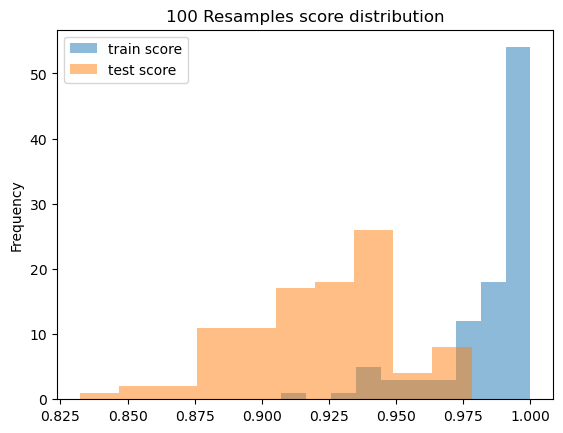

In [ ]:
train_score_series.plot.hist(alpha=0.5,)
test_score_series.plot.hist(alpha=0.5)
plt.legend(['train score', 'test score'])
plt.title(f'{n_samples} Resamples score distribution')
None # hides ugly last line

In [ ]:
np.mean(test_scores) - np.std(test_scores)

0.8895680198848198

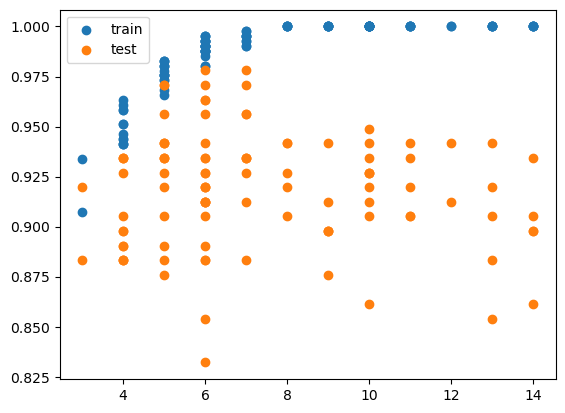

In [ ]:
plt.scatter(depths, train_scores, label='train')
plt.scatter(depths, test_scores, label='test')
plt.legend()

In [ ]:
sorted(depths)

[3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14]